First run I will do without any filtering, that might come later

In [1]:
%run ../scripts/notebook_settings.py

In [2]:
meta_data_samples = pd.read_table("../data/metadata_with_x_missing.txt", sep=" ")

In [3]:
zarr_dir = "/faststorage/project/baboondiversity/data/PG_panu3_zarr_01_03_2021/callset.zarr/chrX"
#Opening the zarr data
callset = zarr.open_group(zarr_dir, mode="r")
gt = allel.GenotypeArray(callset["calldata/GT"])

Filter gt for biallelic sites

In [4]:
ac = gt.count_alleles()[:] #Allele counts for each pos
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1) #Filter for biallelic and presence of alternate
gf = gt.compress(flt, axis=0)
pos = (callset["variants/POS"][:]).compress(flt, axis=0)
print(len(gf), len(gt), len(gf)/len(gt))

2095557 2923212 0.7168679521020028


First, I am going to find shared derived between Species, and then between the clustered origins.
First for the whole X (including PAR here), then for regions

In [5]:
id_dir = {}
for s in meta_data_samples.Species.unique():
    id_dir[s] = meta_data_samples.loc[(meta_data_samples.Species == s)
                                      & (meta_data_samples.Sex == "F")
                                    & (meta_data_samples.PGDP_ID != "PD_0202")
                                    &(meta_data_samples.PGDP_ID != "PD_0690")].callset_index.values

In [6]:
id_dir

{'anubis': array([  0,   1,   4,   6,   7,   9,  10,  11,  12,  13,  20,  22,  23,
         39,  40,  41,  42,  44,  45,  46,  66,  69,  73,  74,  75,  80,
         81,  83,  85,  87,  89,  90,  91,  96,  97,  98,  99, 100, 102,
        104, 105, 107, 108, 143, 146, 148, 152, 158, 159, 160, 166]),
 'cynocephalus': array([ 14,  15,  17,  25,  26,  27,  33,  38,  51,  52,  53,  77,  94,
         95, 167, 176, 187, 191, 192, 194, 195, 196]),
 'papio': array([54, 55, 56, 57, 58]),
 'ursinus (grayfoot)': array([115, 116, 117]),
 'hamadryas': array([120, 122, 123, 130, 132]),
 'kindae': array([182, 203, 210, 211, 212, 213, 214])}

Creating the dataframe and populating it

In [7]:
df_species = pd.DataFrame()
df_species["pos"] = pos
for species in id_dir:
    print(species)
    IDs = id_dir[species]
    gt_species = gf.take(IDs, axis=1)
    ac = gt_species.count_alleles()
    df_species[species] = ac.is_variant()
    print(ac.is_variant().sum())

anubis
768795
cynocephalus
1014142
papio
186541
ursinus (grayfoot)
413304
hamadryas
345121
kindae
559564


Number of sites with no derived (due to males having derived calls)

In [8]:
print((df_species.iloc[:,1:].sum(axis=1) == 0).sum()/len(df_species))

0.17751032303106049


Looking at the distribution of derived sites

In [9]:
df_species["species_derived"] = df_species.iloc[:,1:].sum(axis=1)

In [10]:
df_species["species_derived"].value_counts()

1    997157
0    371983
2    344589
3    137495
4    107654
6     74636
5     62043
Name: species_derived, dtype: int64

<AxesSubplot:xlabel='species_derived', ylabel='Count'>

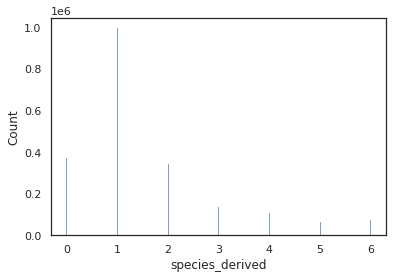

In [11]:
sns.histplot(df_species, x="species_derived")

In [12]:
df_species_r = df_species.loc[df_species.species_derived != 6]

In [13]:
d_d = {}
for s1 in id_dir:
    d_d[s1] = {}
    for s2 in id_dir:
        d_d[s1][s2] =((df_species_r[s1]==True) & (df_species_r[s2]==True)).sum()
derived_df = pd.DataFrame(d_d)
derived_df

,anubis,cynocephalus,papio,ursinus (grayfoot),hamadryas,kindae
anubis,694159,378993,41068,161933,140645,188523
cynocephalus,378993,939506,36207,244258,107259,328655
papio,41068,36207,111905,14221,24299,21034
ursinus (grayfoot),161933,244258,14221,338668,60997,199255
hamadryas,140645,107259,24299,60997,270485,76081
kindae,188523,328655,21034,199255,76081,484928


In [37]:
window_size = 100000
def shared_counting(shared):
    return shared.sum()

df_dict = {}
for s1 in id_dir:
    df_species_list = []
    for s2 in id_dir:
        chrom="chrX"
        shared =((df_species_r[s1]==True) & (df_species_r[s2]==True))
        pos_subset = pos.compress(df_species.species_derived != 6,axis=0)
        nnz, windows, counts = allel.windowed_statistic(pos_subset,
                                                        shared, statistic=shared_counting, size=window_size)
        df = pd.DataFrame()
        df["shared"] = nnz
        window_numbering = []
        df.insert(0, column="chrom", value=chrom)
        window_numbering.extend(range(len(nnz)))
        df.insert(1, column="start", value=window_numbering)
        df.insert(2, column = "pop", value = s2)
        df_species_list.append(df)
    s1_df = pd.concat(df_species_list, axis=0)
    df_dict[s1] = s1_df

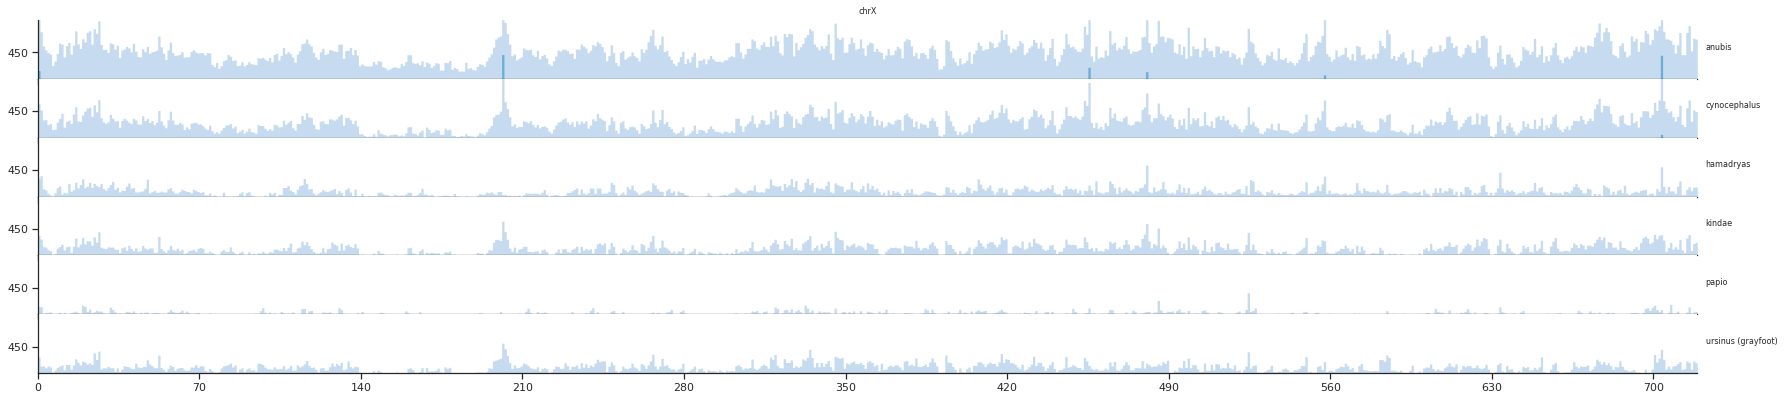

In [38]:
anubis = df_dict["anubis"]
anubis_first_half = anubis.loc[anubis.start <= max(anubis.start)//2]
fig = horizonplot(anubis_first_half, 'shared', width=1, col='chrom', row='pop', size=1, aspect=25, cut=1000)

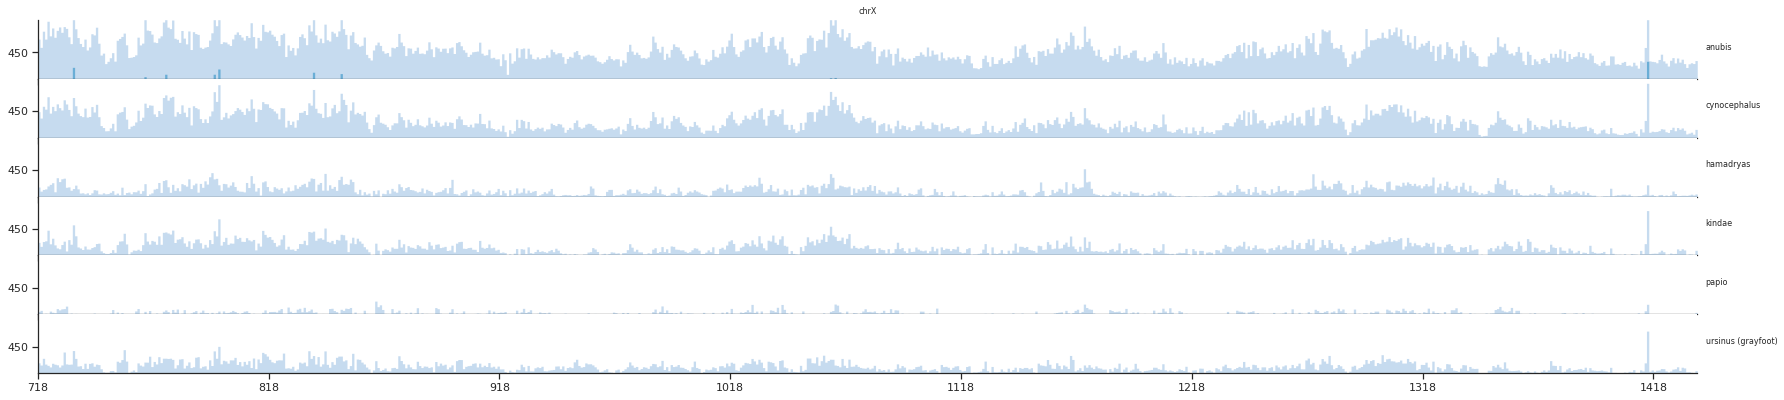

In [39]:
anubis = df_dict["anubis"]
anubis_second_half = anubis.loc[anubis.start >= max(anubis.start)//2]
fig = horizonplot(anubis_second_half, 'shared', width=1, col='chrom', row='pop', size=1, aspect=25, cut=1000)

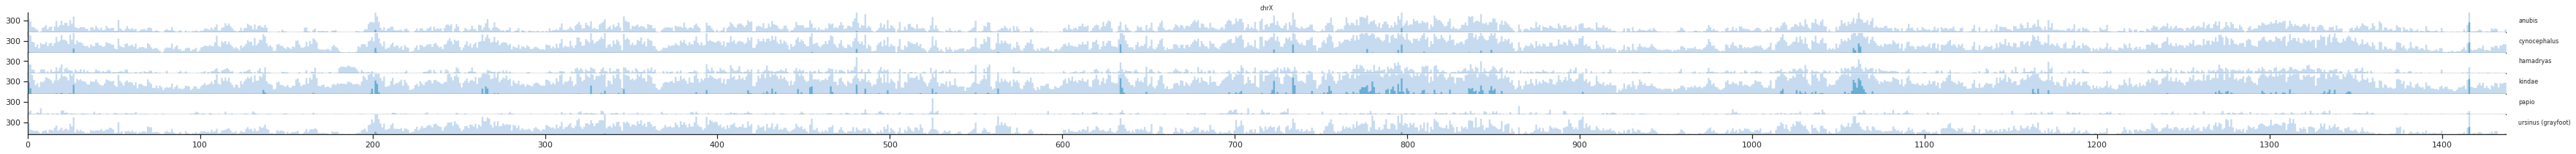

In [40]:
fig = horizonplot(df_dict["kindae"], 'shared', width=1, col='chrom', row='pop', size=0.5, aspect=100, cut=500)

Doing the same, but for the regions

In [41]:
id_dir_region = {}
for r in meta_data_samples.C_origin.unique():
    id_dir_region[r] = meta_data_samples.loc[(meta_data_samples.C_origin == r)
                                      & (meta_data_samples.Sex == "F")].callset_index.values

In [42]:
id_dir_region

{'Anubis, Tanzania': array([  0,   1,   3,   4,   6,   7,   9,  10,  11,  12,  13,  20,  22,
         23,  39,  40,  41,  42,  44,  45,  46,  66,  69,  73,  74,  75,
         80,  81,  83,  85,  87,  89,  90,  91,  96,  97,  98,  99, 100,
        102, 104, 105, 107, 108]),
 'Cynocephalus, Central Tanzania': array([ 14,  15,  17,  25,  26,  27,  38,  51,  52,  53,  77, 112, 167,
        176, 187, 191, 192, 194, 195, 196]),
 'Cynocephalus, Western Tanzania': array([33, 94, 95]),
 'Papio, Senegal': array([54, 55, 56, 57, 58]),
 'Ursinus, Zambia': array([115, 116, 117]),
 'Hamadryas, Ethiopia': array([120, 122, 123, 130, 132]),
 'Anubis, Ethiopia': array([143, 146, 148, 152, 158, 159, 160, 166]),
 'Kindae, Zambia': array([182, 203, 210, 211, 212, 213, 214])}

In [84]:
df_region = pd.DataFrame()
df_region["pos"] = pos
for region in id_dir_region:
    print(region)
    IDs = id_dir_region[region]
    gt_region = gf.take(IDs, axis=1)
    ac = gt_region.count_alleles()
    df_region[region] = ac.is_variant()
    print(ac.is_variant().sum())
df_region["non_ref_sum"] = df_region.iloc[:,1:].sum(axis=1)

Anubis, Tanzania
735292
Cynocephalus, Central Tanzania
941133
Cynocephalus, Western Tanzania
550246
Papio, Senegal
186541
Ursinus, Zambia
413304
Hamadryas, Ethiopia
345121
Anubis, Ethiopia
311378
Kindae, Zambia
559564


In [74]:
print((df_region.iloc[:,1:].sum(axis=1) == 0).sum()/len(df_region))

0.1307413732959781


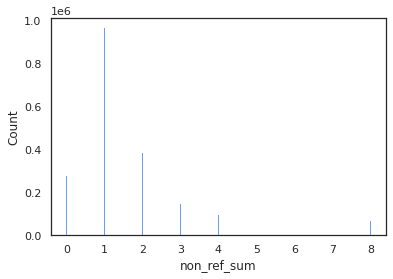

In [85]:
g = sns.histplot(df_region, x="non_ref_sum")
#g.set_yscale("log")

In [86]:
len(df_region.loc[df_region.non_ref_sum ==3])

145662

In [87]:
len(df_region)

2095557

In [95]:
pd.DataFrame(df_region["non_ref_sum"].value_counts()).sort_index()

,non_ref_sum
0,273976
1,962892
2,384191
3,145662
4,92926
5,86014
6,43715
7,39193
8,66988


In [50]:
df_region_r = df_region.loc[df_region.region_derived != 8]

In [51]:
pd.set_option("display.precision", 2)
d_d = {}
for s1 in sorted(id_dir_region):
    d_d[s1] = {}
    total_non_ref = (df_region_r[s1]==True).sum()
    d_d[s1]["n"] = len(id_dir_region[s1])
    d_d[s1]["Total non-ref"] = total_non_ref
    for s2 in sorted(id_dir_region):
        d_d[s1][s2] =((df_region_r[s1]==True) & (df_region_r[s2]==True)).sum()/total_non_ref
derived_df_region = pd.DataFrame(d_d)
derived_df_region

,"Anubis, Ethiopia","Anubis, Tanzania","Cynocephalus, Central Tanzania","Cynocephalus, Western Tanzania","Hamadryas, Ethiopia","Kindae, Zambia","Papio, Senegal","Ursinus, Zambia"
n,8.00,44.00,20.00,3.00,5.00,7.00,5.00,3.00
Total non-ref,244390.00,668304.00,874145.00,483258.00,278133.00,492576.00,119553.00,346316.00
"Anubis, Ethiopia",1.00,0.19,0.09,0.14,0.36,0.12,0.26,0.13
"Anubis, Tanzania",0.53,1.00,0.47,0.49,0.44,0.39,0.39,0.48
"Cynocephalus, Central Tanzania",0.34,0.61,1.00,0.68,0.38,0.53,0.34,0.65
"Cynocephalus, Western Tanzania",0.28,0.36,0.37,1.00,0.32,0.60,0.28,0.59
"Hamadryas, Ethiopia",0.41,0.18,0.12,0.18,1.00,0.17,0.27,0.20
"Kindae, Zambia",0.24,0.28,0.30,0.61,0.30,1.00,0.24,0.60
"Papio, Senegal",0.13,0.07,0.05,0.07,0.11,0.06,1.00,0.06
"Ursinus, Zambia",0.19,0.25,0.26,0.43,0.25,0.42,0.18,1.00


In [52]:
window_size = 100000
def shared_counting(shared):
    return shared.sum()

df_dict = {}
for s1 in sorted(id_dir_region):
    df_species_list = []
    for s2 in sorted(id_dir_region):
        chrom="chrX"
        shared =((df_region_r[s1]==True) & (df_region_r[s2]==True))
        pos_subset = pos.compress(df_region_r.region_derived != 8,axis=0)
        nnz, windows, counts = allel.windowed_statistic(pos_subset,
                                                        shared, statistic=shared_counting, size=window_size)
        df = pd.DataFrame()
        df["shared"] = nnz
        window_numbering = []
        df.insert(0, column="chrom", value=chrom)
        window_numbering.extend(range(len(nnz)))
        df.insert(1, column="start", value=window_numbering)
        df.insert(2, column = "pop", value = s2)
        df_species_list.append(df)
    s1_df = pd.concat(df_species_list, axis=0)
    df_dict[s1] = s1_df

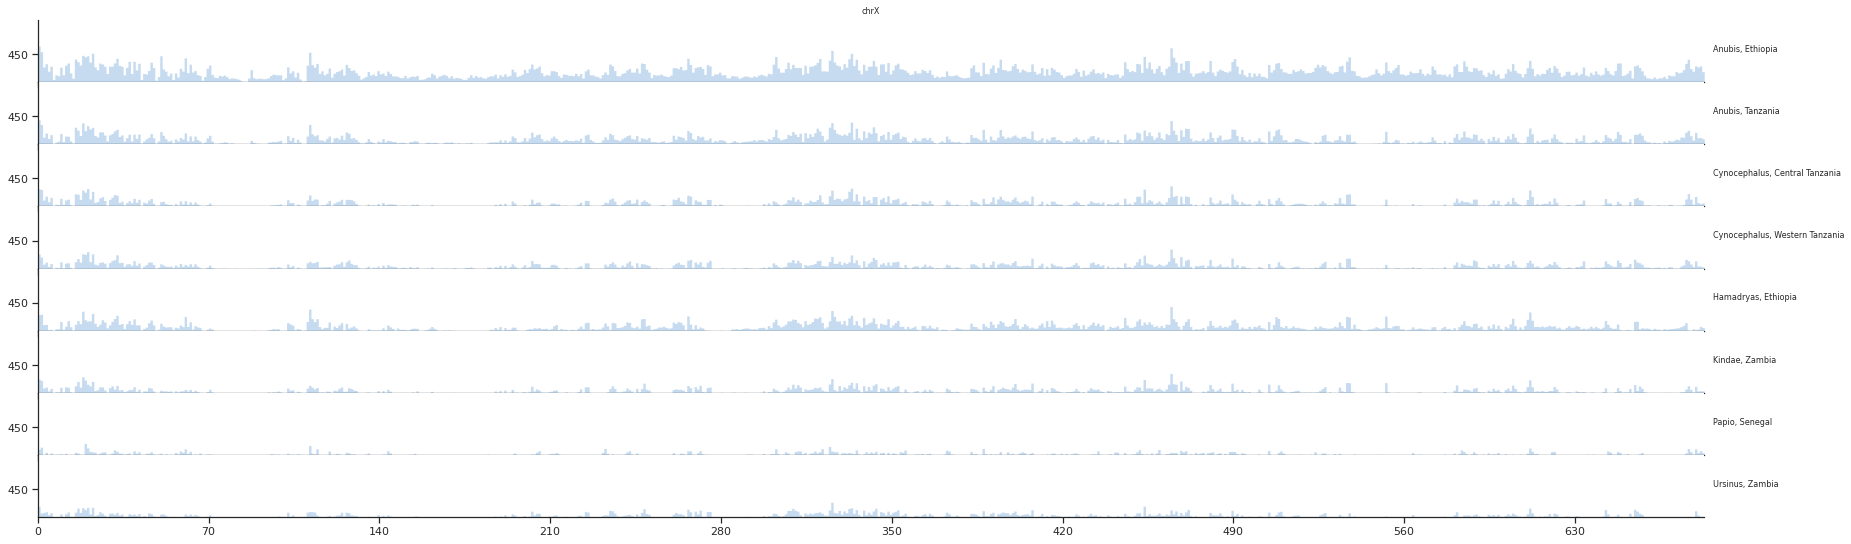

In [54]:
anubis = df_dict["Anubis, Ethiopia"]
anubis_first_half = anubis.loc[anubis.start <= max(anubis.start)//2]
fig = horizonplot(anubis_first_half, 'shared', width=1, col='chrom', row='pop', size=1, aspect=25, cut=1000)

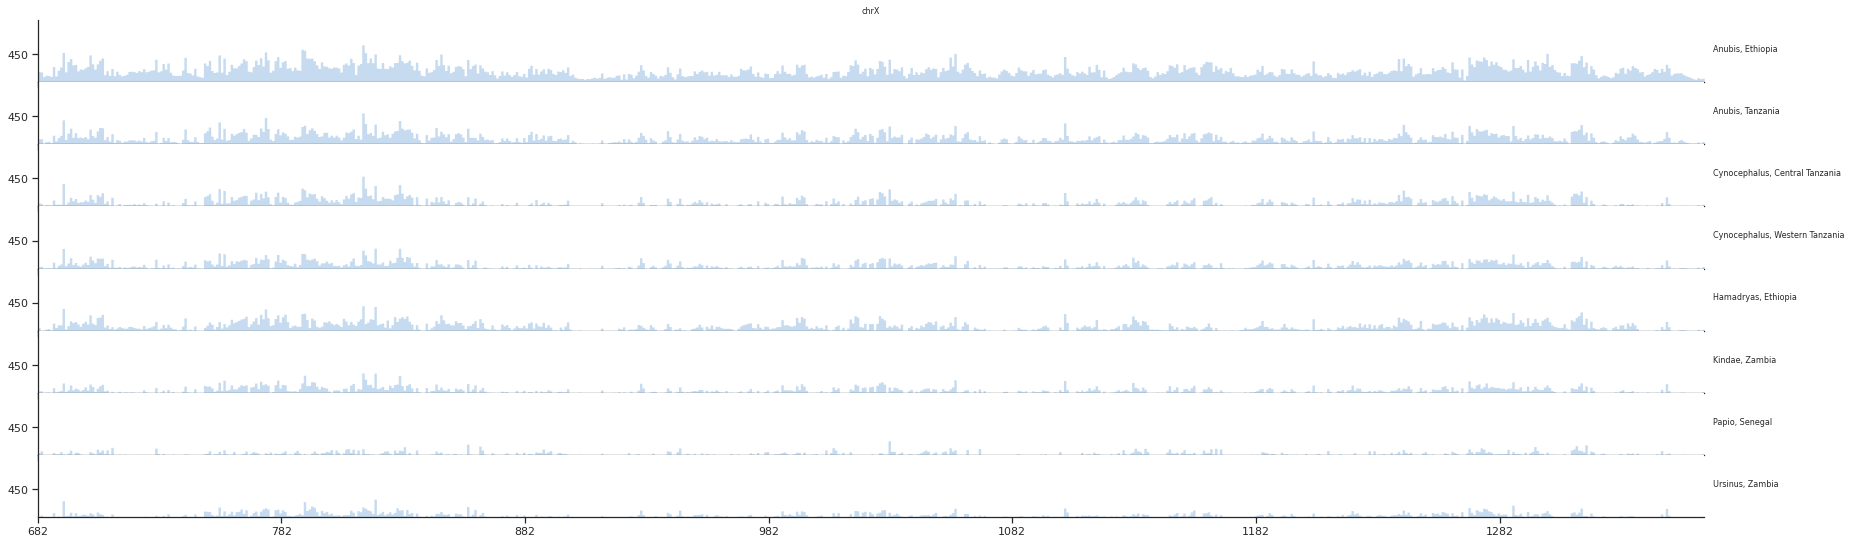

In [53]:
anubis = df_dict["Anubis, Ethiopia"]
anubis_second_half = anubis.loc[anubis.start >= max(anubis.start)//2]
fig = horizonplot(anubis_second_half, 'shared', width=1, col='chrom', row='pop', size=1, aspect=25, cut=1000)